In [ ]:
# Configuração do ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)

IMG_SIZE = 32
BATCH_SIZE = 32
num_classes = 10

# Função para carregar e preprocessar dados de múltiplos diretórios
def load_data_from_directories(directories, img_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE):
    data_gen_list = []
    
    # Itera sobre cada diretório na lista de diretórios fornecida
    for directory in directories:
        # Cria um gerador de dados para o diretório atual
        data_gen = datagen.flow_from_directory(
            directory,                # Diretório atual de onde as imagens serão carregadas
            target_size=img_size,     # Redimensiona as imagens para o tamanho especificado (img_size)
            batch_size=batch_size,    # Número de imagens a serem carregadas em cada lote (batch)
            class_mode='categorical', # Define o modo de classe como 'categorical' para classificação
            shuffle=True              # Embaralha as imagens para garantir uma mistura aleatória
        )
        data_gen_list.append(data_gen)
    
    # Inicializa listas vazias para armazenar os dados das imagens e os rótulos
    data, labels = [], []
    
    # Itera sobre cada gerador de dados na lista de geradores
    for data_gen in data_gen_list:
        # Itera sobre o gerador de dados para carregar todos os lotes de imagens e rótulos
        for _ in range(len(data_gen)):
            # Carrega o próximo lote de dados e rótulos do gerador
            batch_data, batch_labels = data_gen.next()
            # Adiciona o lote de dados à lista de dados
            data.append(batch_data)
            # Adiciona o lote de rótulos à lista de rótulos
            labels.append(batch_labels)
    
    # Concatena todas as listas de lotes em um único array para dados e rótulos, respectivamente
    return np.vstack(data), np.vstack(labels)

# Carregar dados de treino de múltiplos diretórios
# Chama a função definida acima passando a lista de diretórios de treino, o tamanho das imagens e o tamanho do lote
X_train, y_train = load_data_from_directories(train_dirs, img_size=(IMG_SIZE, 32), batch_size=BATCH_SIZE)

validation_dataset = datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    
)

test_dataset = datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    
)

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow import keras

# Diretórios de dados
base_dir = 'Imagens/'
train_dirs = [os.path.join(base_dir, f'train/train{i}/') for i in range(1, 5)]
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [37]:
#Criar o modelo

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')
    ])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_25 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_25 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_26 (Ba  (None, 16, 16, 64)       

In [39]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.000001)#Vai reduzindo o lr quando tiver mais proximo do objetivo

In [40]:
# Treinar o modelo
history = model.fit(X_train, y_train, epochs=100, batch_size=BATCH_SIZE ,validation_data=validation_dataset, callbacks=[early_stopping, reduce_lr])

Epoch 1/100
1250/1250 [==============================] - 34s 25ms/step - loss: 2.8561 - accuracy: 0.3627 - val_loss: 2.4170 - val_accuracy: 0.4377 - lr: 0.0010
Epoch 2/100
1250/1250 [==============================] - 31s 25ms/step - loss: 2.1137 - accuracy: 0.4981 - val_loss: 1.9531 - val_accuracy: 0.5250 - lr: 0.0010
Epoch 3/100
1250/1250 [==============================] - 32s 26ms/step - loss: 1.8534 - accuracy: 0.5566 - val_loss: 1.9021 - val_accuracy: 0.5136 - lr: 0.0010
Epoch 4/100
1250/1250 [==============================] - 31s 25ms/step - loss: 1.7721 - accuracy: 0.5862 - val_loss: 1.9912 - val_accuracy: 0.5092 - lr: 0.0010
Epoch 5/100
1250/1250 [==============================] - 31s 25ms/step - loss: 1.7594 - accuracy: 0.6054 - val_loss: 2.2451 - val_accuracy: 0.4928 - lr: 0.0010
Epoch 6/100
1250/1250 [==============================] - 31s 25ms/step - loss: 1.7497 - accuracy: 0.6193 - val_loss: 1.5952 - val_accuracy: 0.6770 - lr: 0.0010
Epoch 7/100
1250/1250 [=================

In [41]:
#Saving the model
model.save('Primeiro_treino_AllTrains.h5')

c:\Users\MvCrespo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [42]:
model = keras.models.load_model('Primeiro_treino_AllTrains.h5')
# Validacao da Rede
val_loss, val_acc = model.evaluate(validation_dataset)
print('val_acc:', val_acc)

# Avaliar o modelo
test_loss, test_acc = model.evaluate(test_dataset)
print(f'Test accuracy: {test_acc}')

313/313 [==============================] - 4s 12ms/step - loss: 0.6615 - accuracy: 0.8427
val_acc: 0.8427000045776367
313/313 [==============================] - 4s 12ms/step - loss: 0.6814 - accuracy: 0.8372
Test accuracy: 0.8371999859809875


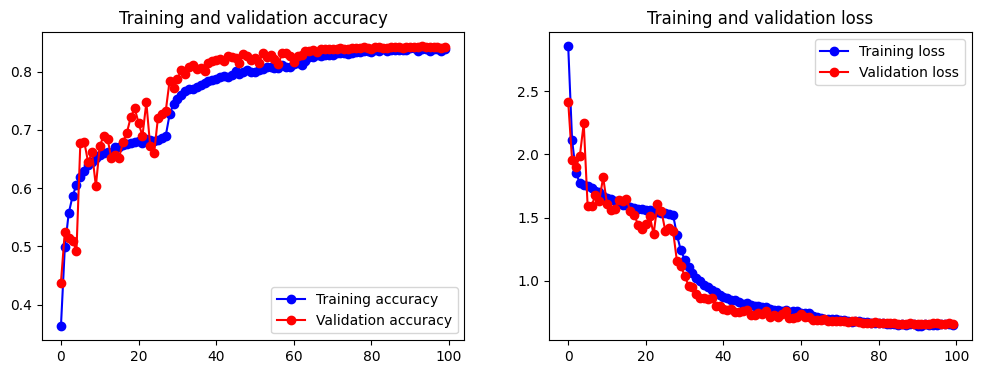

In [43]:
# Plotando os resultados
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_training_history(history)